<a href="https://www.kaggle.com/code/lz82117/water-stress-classification?scriptVersionId=97567855" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**water stress level prediction**

In this notebook, we try to build a classification model to predict the water stress level of a country given some features of the country. 

Water stress definition: 
Freshwater withdrawal as a proportion of available freshwater resources. It is the ratio between total freshwater withdrawn by all major sectors and total renewable freshwater resources, after taking into account environmental flow requirements.

[SDG 6.4.2. Water Stress] = 100*[Total freshwater withdrawal]/([Total renewable water resources]-[Environmental Flow Requirements])

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

Load and view aquastat data set

In [2]:
df = pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/ultimate+aquastat+(flat).csv')  # will be used for Time series analysis
df_GDP = pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/GDP.csv')

In [3]:
table=pd.pivot_table(data=df,values='Value',index=['Area','Year'],columns='Variable Name')

# drop undernourishment and add GDP  
table = table.drop('Prevalence of undernourishment (3-year average)', axis=1)  # TODO download correct data from AQUASTAT instead of dropping here
table_GDP = pd.pivot_table(data=df_GDP,values='Value',index=['Area','Year'],columns='Variable Name')
table
table = table.merge(table_GDP, how='inner', on=['Area','Year'])
table.head(21)

Variable Name       Agricultural water withdrawal as % of total renewable water resources  \
Area        Year                                                                            
Afghanistan 1992.0                                          35.498101                       
            1997.0                                          31.427856                       
            2002.0                                          30.613807                       
            2007.0                                          30.613807                       
            2012.0                                          30.613807                       
            2017.0                                          30.613807                       
            2018.0                                          30.613807                       
Argentina   1992.0                                                NaN                       
            1997.0                                           2.455948                       
            2002.0                                           2.588954                       
            2007.0                                           2.921470                       
            2012.0                                           3.187483                       
            2017.0                                           3.187483                       
            2018.0                                           3.187483                       
Australia   1992.0                                                NaN                       
            1997.0                                           3.131301                       
            2002.0                                           2.913110                       
            2007.0                                           1.987195                       
            2012.0                                           1.948577                       
            2017.0                                           2.250000                       
            2018.0                                           2.444073                       

Variable Name       Agriculture, value added (% GDP)  Average Temperature  \
Area        Year                                                            
Afghanistan 1992.0                         54.207106                12.61   
            1997.0                         62.416768                12.86   
            2002.0                         45.134344                13.91   
            2007.0                         35.265942                13.80   
            2012.0                         28.556142                13.25   
            2017.0                         25.574670                13.12   
            2018.0                         22.440899                14.55   
Argentina   1992.0                          5.193747                14.37   
            1997.0                          4.527197                15.14   
            2002.0                          8.848660                14.60   
            2007.0                          7.452354                14.20   
            2012.0                          5.781744                15.20   
            2017.0                          5.478382                15.30   
            2018.0                          6.097129                14.99   
Australia   1992.0                          3.263718                21.75   
            1997.0                          3.038954                21.82   
            2002.0                          2.888534                22.25   
            2007.0                          2.338630                22.08   
            2012.0                          2.278906                21.83   
            2017.0                          2.458346                22.57   
            2018.0                          2.121597                22.58   

Variable Name       Environmental Flow Requirements  GDP per capita  \
Area        Year 

### Data cleaning

The complete timetable has missing values for some of the oldest observations. By looking at the data, one notices a certain trend over the years for each variable and each country. This idea is used to fill the missing values. 

Using interpolation to fill the data gaps would be ideal. Since our dataset consists of MultiIndexes, a linear interpolation is the only possible option. However, linear interpolation is not useful in this situation, since the missing values occur only in the oldest observation. Those values are unfortunately not linearly interpolated, simply because there is no value to base the 'inter'polation on.

Hence, 'bfill' is used to fill the data gaps. A possible improvement here would be to create a dataframe using a single index (e.g. a dataframe per country and 'Year' as index) and to perform a spline interpolation, which can extrapolate NaNs at the tail of a Series/Dataframe.

In [4]:
# # Could be done like this if dataframe has no MultiIndexes
# rev_table = table.iloc[::-1]
# rev_table_preprocessed = rev_table.interpolate(method='spline', order=2, axis=0)
# table = rev_table_preprocessed.iloc[::-1]

table_preprocessed = table.fillna(method='bfill')
table_preprocessed.head(21)

Variable Name       Agricultural water withdrawal as % of total renewable water resources  \
Area        Year                                                                            
Afghanistan 1992.0                                          35.498101                       
            1997.0                                          31.427856                       
            2002.0                                          30.613807                       
            2007.0                                          30.613807                       
            2012.0                                          30.613807                       
            2017.0                                          30.613807                       
            2018.0                                          30.613807                       
Argentina   1992.0                                           2.455948                       
            1997.0                                           2.455948                       
            2002.0                                           2.588954                       
            2007.0                                           2.921470                       
            2012.0                                           3.187483                       
            2017.0                                           3.187483                       
            2018.0                                           3.187483                       
Australia   1992.0                                           3.131301                       
            1997.0                                           3.131301                       
            2002.0                                           2.913110                       
            2007.0                                           1.987195                       
            2012.0                                           1.948577                       
            2017.0                                           2.250000                       
            2018.0                                           2.444073                       

Variable Name       Agriculture, value added (% GDP)  Average Temperature  \
Area        Year                                                            
Afghanistan 1992.0                         54.207106                12.61   
            1997.0                         62.416768                12.86   
            2002.0                         45.134344                13.91   
            2007.0                         35.265942                13.80   
            2012.0                         28.556142                13.25   
            2017.0                         25.574670                13.12   
            2018.0                         22.440899                14.55   
Argentina   1992.0                          5.193747                14.37   
            1997.0                          4.527197                15.14   
            2002.0                          8.848660                14.60   
            2007.0                          7.452354                14.20   
            2012.0                          5.781744                15.20   
            2017.0                          5.478382                15.30   
            2018.0                          6.097129                14.99   
Australia   1992.0                          3.263718                21.75   
            1997.0                          3.038954                21.82   
            2002.0                          2.888534                22.25   
            2007.0                          2.338630                22.08   
            2012.0                          2.278906                21.83   
            2017.0                          2.458346                22.57   
            2018.0                          2.121597                22.58   

Variable Name       Environmental Flow Requirements  GDP per capita  \
Area        Year 

### Data Preprocessing and exploration


Calculate the new variables, drop the old ones, divide the water stress indicator into 5 risk levels

In [5]:
data=table_preprocessed.copy()
data['Industry, value added (% GDP)']=data['Industry, value added to GDP']/data['Gross Domestic Product (GDP)']*100
data['Services, value added (% GDP)']=data['Services, value added to GDP']/data['Gross Domestic Product (GDP)']*100
data.drop(['Services, value added to GDP','Industry, value added to GDP'],axis=1,inplace=True)
data['stressclass'] = pd.cut(data['SDG 6.4.2. Water Stress'],bins=[0,25,50,75,100,200],labels=['0','1','2','3','4'])

In [6]:
data.head()

Variable Name       Agricultural water withdrawal as % of total renewable water resources  \
Area        Year                                                                            
Afghanistan 1992.0                                          35.498101                       
            1997.0                                          31.427856                       
            2002.0                                          30.613807                       
            2007.0                                          30.613807                       
            2012.0                                          30.613807                       

Variable Name       Agriculture, value added (% GDP)  Average Temperature  \
Area        Year                                                            
Afghanistan 1992.0                         54.207106                12.61   
            1997.0                         62.416768                12.86   
            2002.0                         45.134344                13.91   
            2007.0                         35.265942                13.80   
            2012.0                         28.556142                13.25   

Variable Name       Environmental Flow Requirements  GDP per capita  \
Area        Year                                                      
Afghanistan 1992.0                            28.29      248.518890   
            1997.0                            28.29      164.092893   
            2002.0                            28.29      194.958382   
            2007.0                            28.29      389.985586   
            2012.0                            28.29      694.885618   

Variable Name       Long-term average annual precipitation in volume  \
Area        Year                                                       
Afghanistan 1992.0                                         213.48522   
            1997.0                                         213.48522   
            2002.0                                         213.48522   
            2007.0                                         213.48522   
            2012.0                                         213.48522   

Variable Name       MDG 7.5. Freshwater withdrawal as % of total renewable water resources  \
Area        Year                                                                             
Afghanistan 1992.0                                          35.910480                        
            1997.0                                          31.852952                        
            2002.0                                          31.045461                        
            2007.0                                          31.045461                        
            2012.0                                          31.045461                        

Variable Name       National Rainfall Index (NRI)  Population density  \
Area        Year                                                        
Afghanistan 1992.0                         304.98           22.187829   
            1997.0                         233.00           29.649735   
            2002.0                         185.00           34.618096   
            2007.0                         185.00           41.510486   
            2012.0                         185.00           47.730564   

Variable Name       SDG 6.4.1. Industrial Water Use Efficiency  ...  \
Area        Year                                                ...   
Afghanistan 1992.0                                   25.311413  ...   
            1997.0                                    9.091408  ...   
            2002.0                                   11.426285  ...   
            2007.0                                   20.815284  ...   
            2012.0                                   23.227115  ...   

Variable Name       SDG 6.4.1. Services Water Use Efficiency  \
Area        Year                                               
Afghanis

In [7]:
data.isnull().any()

Variable Name
Agricultural water withdrawal as % of total renewable water resources     False
Agriculture, value added (% GDP)                                          False
Average Temperature                                                       False
Environmental Flow Requirements                                           False
GDP per capita                                                            False
Long-term average annual precipitation in volume                          False
MDG 7.5. Freshwater withdrawal as % of total renewable water resources    False
National Rainfall Index (NRI)                                             False
Population density                                                        False
SDG 6.4.1. Industrial Water Use Efficiency                                False
SDG 6.4.1. Irrigated Agriculture Water Use Efficiency                     False
SDG 6.4.1. Services Water Use Efficiency                                  False
SDG 6.4.1. Water Use Effic

In [8]:
print(data['SDG 6.4.2. Water Stress'].describe())

count    259.000000
mean      36.010942
std       35.990617
min        0.173148
25%        7.967094
50%       27.740468
75%       52.929939
max      168.924577
Name: SDG 6.4.2. Water Stress, dtype: float64


the distribution of water stress index

<AxesSubplot:>

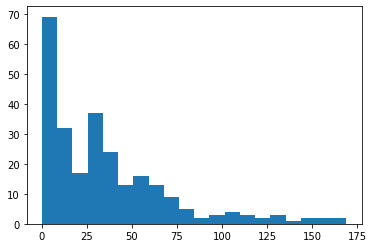

In [9]:
data['SDG 6.4.2. Water Stress'].hist(grid=False, bins=20)

right skewed


## Classification

In [10]:
X=data.iloc[:,0:23].drop(
    ['Environmental Flow Requirements',
     'Total renewable water resources per capita',
     'SDG 6.4.2. Water Stress',
     'MDG 7.5. Freshwater withdrawal as % of total renewable water resources',
     'stressclass'],axis=1)
y=data['stressclass']

drop the features in the calculation of water stress level  

In [11]:
X_train, X_test, y_train, y_test  = train_test_split(X,y,test_size=0.2,random_state=0,shuffle=True,stratify=y)

split the data into train set and test set

### Create pipeline framework

In [12]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('selector', SelectKBest(mutual_info_classif, k=5)),
                 ('classifier', LogisticRegression())])

### create search space


In [13]:
search_space = [{'selector__k': [5, 6, 7, 8, 9, 10]},
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators':[30, 50, 100],
                 'classifier__max_features': [1, 2, 3],
                 'classifier__min_samples_leaf':[1, 2, 3]},
                {'classifier': [LogisticRegression(max_iter=7000)]},
                {'classifier': [naive_bayes.GaussianNB()]},
                {'classifier': [KNeighborsClassifier()],
                 'classifier__leaf_size': [5,10,15,30],
                 'classifier__n_neighbors': [5,10,15]}]

### model selection

In [14]:
clf = GridSearchCV(pipe, search_space, cv=5, verbose=0)
clf = clf.fit(X_train, y_train)


best_pipe=clf.best_estimator_
features = best_pipe.named_steps['selector']

In [15]:
print("Best params:\n{}\n".format(clf.best_params_))
print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best estimator:\n{}\n".format(clf.best_estimator_))
print("Selected features:\n{}\n".format(X_train.columns[features.get_support()]))

Best params:
{'classifier': RandomForestClassifier(max_features=3), 'classifier__max_features': 3, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100}

Best cross-validation score: 0.93
Best estimator:
Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x7f4a675ad5f0>)),
                ('classifier', RandomForestClassifier(max_features=3))])

Selected features:
Index(['Agricultural water withdrawal as % of total renewable water resources',
       'Average Temperature',
       'Long-term average annual precipitation in volume',
       'National Rainfall Index (NRI)', 'Population density'],
      dtype='object', name='Variable Name')



The best 5 features to predict water stress level: 
'Agricultural water withdrawal as % of total renewable water resources',
       'Average Temperature',
       'Long-term average annual precipitation in volume',
       'National Rainfall Index (NRI)', 'Population density'
       
 Best classification algorithm: random forest classifer
 
 Temperature, precipitation, population and agricultural water withdrawal have an effect on water stress.

### Model validation

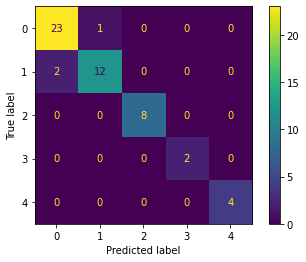

In [16]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

In [17]:
y_pred=clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9423076923076923

high accuracy, model fits well

### next step: VAR model

We build a model with which we can predict the water stress levels based on these predictors, 'Agricultural water withdrawal as % of total renewable water resources', 'Average Temperature', 'Long-term average annual precipitation in volume','National Rainfall Index (NRI)', 'Population density'. 
But we cannot forecast the future water stress levels since we don't know the future predictors. So, we turn to a time series model, Vector Autoregression model. 